# PhageHostPredict - HDC (Klebsiella)

A Phage-Host interaction predictor framework based on Hyperdimensional Computing with receptors and receptor-binding proteins at its core. This particular PhageHostPredict is for *Klebsiella pneumoniae* related phages.

This notebook follows after having ran the PhageHostPredict_processing steps implemented in the accompanying Python script.

The predictive framework works as follows:

1. [Defining the necessary functions](#functions)
2. [Transform the RBP sequence into an embedding](#rbpembed) using hyperdimensional vectors
3. [Exploration of the embeddings](#explore)

## 0 - Libraries and directories

In [1]:
using CSV
using MLJ
using Test
using JSON
using Plots
using FASTX
using MLBase
using Colors
using Random
using XGBoost
using StatsBase
using Statistics
using DataFrames
using ScikitLearn
using BioAlignments
using ProgressMeter
using LinearAlgebra
using ProgressMeter
using BioAlignments
using DelimitedFiles
using MultivariateStats
using ScikitLearn.Pipelines: Pipeline

@sk_import decomposition: PCA
@sk_import ensemble: RandomForestClassifier

push!(LOAD_PATH, "/Users/dimi/Documents/GitHub/HyperdimensionalComputing.jl/src/")
using HyperdimensionalComputing

general_dir = "/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/42_DATA/Valencia_data" # general directory
results_dir = "/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/43_RESULTS/models"
data_suffix = "Valencia"; # choose a suffix for the created data files

## 1 - Functions<a name="functions"></a>

In [2]:
function file_to_array(file)
    """
    Function that reads a FASTA file and puts its sequences in an array.
    """
    sequences = []
    reader = FASTA.Reader(open(file, "r"))
    for record in reader
        seq = FASTA.sequence(record)
        push!(sequences, seq)
    end
    return sequences
end

file_to_array (generic function with 1 method)

In [3]:
function mean_reciprocal_rank(queries)
    """
    This function computes the mean reciprocal rank for a given array or
    matrix of queries. It deals with relevant vs. non-relevant queries that are
    binary. If queries is a matrix, then it will compute the reciprocal ranks over
    all rows individually (for each 'query') and then average those.
    E.g.:
    queries = [[0, 0, 0], [0, 1, 0], [1, 0, 0]]
    mean_reciprocal_rank(queries) -> 0.5
    """
    if isa(queries, Matrix)
        queries_list = [queries[i,:] for i in 1:size(queries)[1]]
        reciprocal_ranks = [sum(query) > 0 ? 1/argmax(query) : 0 for query in queries_list]
    else
        reciprocal_ranks = [sum(query) > 0 ? 1/argmax(query) : 0 for query in queries]
    end
    return mean(reciprocal_ranks)
end

mean_reciprocal_rank (generic function with 1 method)

In [4]:
function sort_label_matrix(score_matrix, label_matrix)
    """
    This function sorts the label matrix based on the score matrix.
    It does so per row (corresponding to bacteria in our setting).
    
    WARNING: The sortperm function will rank equal elements by ascending index order. 
    This potentially can cause an underestimation of performance (MRR), as it can be that 
    an irrelevant 0 appears earlier and then is place before a relevant 1.
    """
    @assert size(label_matrix) == size(score_matrix)
    sorted_matrix = zeros(Int64, size(label_matrix)[1], size(label_matrix)[2])
    for i in 1:size(label_matrix)[1] # loop over rows
        label_row = label_matrix[i,:]
        score_row = score_matrix[i,:]
        sorted_row = label_row[sortperm(score_row, rev=true)]
        sorted_matrix[i,:] = sorted_row
    end
    return sorted_matrix
end

sort_label_matrix (generic function with 1 method)

In [5]:
function mrr_from_scores(score_matrix, label_matrix)
    """
    This function is a wrapper for the previous functions that computes
    the MRR starting from a matrix of (prediction) scores, a threshold above
    which to consider an interaction positive and a label matrix.
    """
    # sort the matrix per row and compute
    replace!(label_matrix, missing => 0)
    sorted_matrix = sort_label_matrix(score_matrix, label_matrix)
    
    return mean_reciprocal_rank(sorted_matrix)
end

mrr_from_scores (generic function with 1 method)

In [6]:
function auc_from_scores(scores_flat, labels_flat)
    """
    This function computes the AUC from raw scores returned by ScikitLearn classifiers.
    For the AUC, we need the flat versions of scores and labels that don't contain missing 
    values (if not, this will skew the results).
    
    Dependencies: MLJ
    """
    c = ["neg", "pos"]
    labels_cat = categorical(c[labels_flat .+ 1])
    scores_uni = [UnivariateFinite(categorical(["neg", "pos"]), [1.0 - p, p]) for p in scores_flat]
    AUC = auc(scores_uni, labels_cat)
    return AUC
end

auc_from_scores (generic function with 1 method)

In [7]:
function compute_performance(score_matrix, label_matrix, scores_flat, labels_flat)
    """
    Wrapper function that computes the two relevant results we want to compare for 
    our models: the ROC AUC and the MRR.    
    """
    MRR = mrr_from_scores(score_matrix, label_matrix) # compute MRR
    AUC = auc_from_scores(scores_flat, labels_flat) # compute AUC
    return MRR, AUC
end

compute_performance (generic function with 1 method)

## 2 - Computing embeddings & signatures<a name="rbpembed"></a>

In this section, we define hyperdimensional vectors for the amino-acid alphabet and use these hyperdimensional vectors to construct *hyperdimensional embeddings* for our loci proteins and RBPs. For the loci proteins, this is a multi-instance setting: multiple proteins will be embedded into hyperdimensional space and then those vectors are aggregated to form one final vector for each locus.

In [8]:
# load data and set names
RBPbase = DataFrame(CSV.File(general_dir*"/RBPbase"*data_suffix*".csv"))
LociBase = JSON.parsefile(general_dir*"/Locibase"*data_suffix*".json")
IM = DataFrame(CSV.File(general_dir*"/interactions_mono"*data_suffix*".csv"))
interaction_matrix = Matrix(IM[1:end, 2:end])
loci_names = IM.accession
serotypes = DataFrame(CSV.File(general_dir*"/serotypes"*data_suffix*".csv"))
rbp_names = names(IM)[2:end];

In [9]:
# define protein alphabet
alphabet = "GAVLIFPSTYCMKRHWDENQX"
basis = Dict(c=>BipolarHDV() for c in alphabet);

In [10]:
# compute loci embeddings w/ proteins (multi-instance)
loci_embeddings = Array{BipolarHDV}(undef, length(LociBase))
for (i, (name, proteins)) in enumerate(LociBase)
    # bind within one sequence, then aggregate the different sequences
    protein_hdvs = [sequence_embedding(string(sequence), basis, 3) for sequence in proteins]
    loci_hdv = HyperdimensionalComputing.aggregate(protein_hdvs)
    loci_embeddings[i] = loci_hdv
end

In [11]:
# compute rbp embeddings
rbp_embeddings = Array{BipolarHDV}(undef, length(RBPbase.ProteinSeq))
for (i, sequence) in enumerate(RBPbase.ProteinSeq)
    rbp_embeddings[i] = sequence_embedding(string(sequence), basis, 3)
end

In [12]:
# compute the rbp-receptor signatures (bind operation)
signatures_pos = Dict()
signatures_neg = Dict()
for (i, loci_embedding) in enumerate(loci_embeddings)
    for (j, rbp_embedding) in enumerate(rbp_embeddings)
        if isequal(interaction_matrix[i,j], 1)
            signatures_pos[(i,j)] = HyperdimensionalComputing.bind([loci_embedding, rbp_embedding])
        elseif isequal(interaction_matrix[i,j], 0)
            signatures_neg[(i,j)] = HyperdimensionalComputing.bind([loci_embedding, rbp_embedding])
        end
    end
end
#signatures_pos = convert(Array{BipolarHDV}, signatures_pos)
#signatures_neg = convert(Array{BipolarHDV}, signatures_neg)
println("pos: ", length(signatures_pos), " neg: ", length(signatures_neg))

pos: 29 neg: 1211


## 3 - Exploration<a name="explore"></a>

In this section, we explore the data and the computed embeddings.

#### Unique serotypes

Most serotypes are unique, and thus only occur the number of times we have RBPs in the dataset (currently 19, 6/5/22).

In [9]:
serotypes = serotypes[:,1]
B = [(i, count(==(i), serotypes)) for i in unique(serotypes)]

60-element Vector{Tuple{String3, Int64}}:
 ("K41", 1)
 ("K15", 1)
 ("K14", 1)
 ("K43", 1)
 ("K74", 2)
 ("K5", 1)
 ("K62", 1)
 ("K22", 1)
 ("K18", 1)
 ("K20", 1)
 ("K25", 1)
 ("K46", 1)
 ("K2", 1)
 ⋮
 ("K9", 1)
 ("K82", 1)
 ("K38", 1)
 ("K50", 1)
 ("K3", 1)
 ("K17", 1)
 ("K57", 1)
 ("K10", 1)
 ("K56", 1)
 ("K54", 1)
 ("K24", 1)
 ("K1", 1)

#### PCA of the RBP embeddings

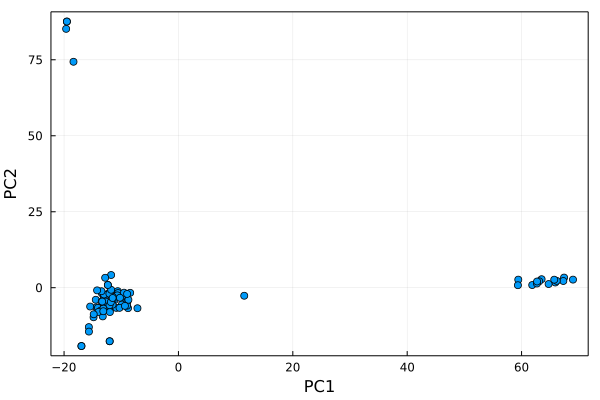

In [15]:
# flip the embeddings for PCA
rbp_embeddings_flipped = zeros(Int64, 10000, length(RBPbase.ProteinSeq))
for i in range(1, length=length(RBPbase.ProteinSeq))
    rbp_embeddings_flipped[:,i] = rbp_embeddings[i]
end

# compute the PCA
pca = fit(MultivariateStats.PCA, rbp_embeddings_flipped, pratio=1, maxoutdim=4)
proj = projection(pca) # each column is a principal component
percent_total_variance = principalvars(pca) ./ tvar(pca) * 100

# visualize
rbp_transformed = MultivariateStats.transform(pca, rbp_embeddings_flipped)
h = plot(rbp_transformed[1,:], rbp_transformed[2,:], seriestype=:scatter, label="")
plot!(xlabel="PC1", ylabel="PC2", framestyle=:box)

#### PCA of loci embeddings

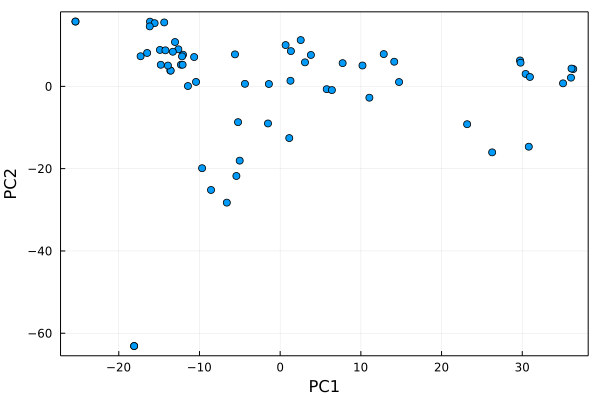

In [24]:
# flip the embeddings for PCA
loci_embeddings_flipped = zeros(Int64, 10000, length(LociBase))
for i in range(1, length=length(LociBase))
    loci_embeddings_flipped[:,i] = loci_embeddings[i]
end

# compute the PCA
pca = fit(MultivariateStats.PCA, loci_embeddings_flipped, pratio=1, maxoutdim=4)
percent_total_variance = principalvars(pca) ./ tvar(pca) * 100

# visualize
loci_transformed = MultivariateStats.transform(pca, loci_embeddings_flipped)
h = plot(loci_transformed[1,:], loci_transformed[2,:], seriestype=:scatter, label="")
plot!(xlabel="PC1", ylabel="PC2", framestyle=:box)

We could color these by serotype but as seen above almost all of the serotypes are unique so the colors would al be unique colors as well. What's important here is to see some variation across the serotypes in two dimensions. We also have indications that some serotypes are more alike than others and cluster together a little. What is the reason for this? Do these possess similar genes?

#### PCA of the signatures colored by RBP

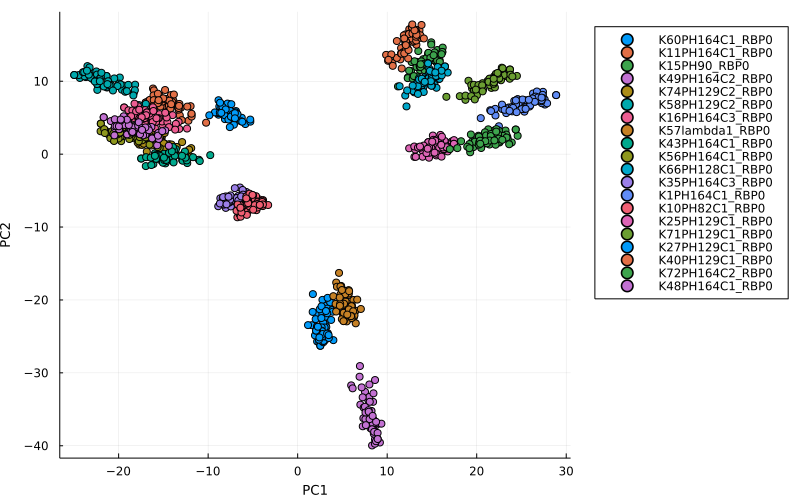

In [13]:
# flip the signatures for PCA
len_signatures = length(signatures_pos)+length(signatures_neg)
signatures_flipped = zeros(Int64, 10000, len_signatures)
labels = []

i = 1
for (key, value) in signatures_pos
    signatures_flipped[:,i] = value
    push!(labels, rbp_names[key[2]])
    i = i+1
end
for (key, value) in signatures_neg
    signatures_flipped[:,i] = value
    push!(labels, rbp_names[key[2]])
    i = i+1
end

# compute the PCA
pca = fit(MultivariateStats.PCA, signatures_flipped, pratio=1, maxoutdim=4);

# visualize
signatures_transformed = MultivariateStats.transform(pca, signatures_flipped)

h = plot(seriestype=:scatter, legend = :outertopright)
for label in unique(labels)
    idx = [i for (i, lab) in enumerate(labels) if lab == label]
    plot!([signatures_transformed[1, idx]], [signatures_transformed[2, idx]], seriestype=:scatter, label=label)  
end
plot!(xlabel="PC1", xguidefontsize=9, ylabel="PC2", yguidefontsize=9, size=(800, 500), dpi=400)
display(h)

In [ ]:
savefig(h, results_dir*"/HDC_PCA_signatures_RBPcolor.png")

#### PCA of the signatures colored by interaction

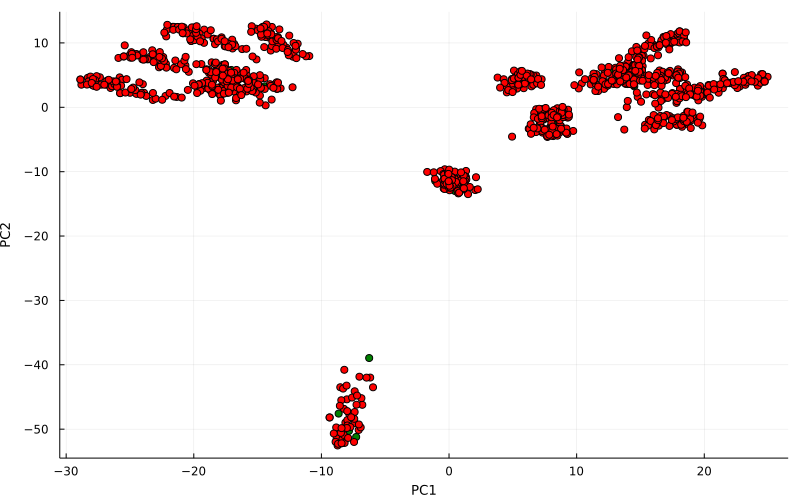

In [14]:
len_signatures = length(signatures_pos)+length(signatures_neg)
signatures_flipped = zeros(Int64, 10000, len_signatures)
labels = vcat([1 for x in signatures_pos], [0 for x in signatures_neg])
colors = Dict(0=>:red, 1=>:green)

i = 1
for (key, value) in signatures_pos
    signatures_flipped[:,i] = value
    i = i+1
end
for (key, value) in signatures_neg
    signatures_flipped[:,i] = value
    i = i+1
end

pca = fit(MultivariateStats.PCA, signatures_flipped, pratio=1, maxoutdim=4);
signatures_transformed = MultivariateStats.transform(pca, signatures_flipped)

h = plot(seriestype=:scatter)
for i in 1:length(labels)
    plot!([signatures_transformed[1, i]], [signatures_transformed[2, i]], seriestype=:scatter, 
        color=colors[labels[i]], legend=false)  
end
plot!(xlabel="PC1", xguidefontsize=9, ylabel="PC2", yguidefontsize=9, size=(800, 500), dpi=400)
display(h)

#### PCA of the signatures colored by serotype

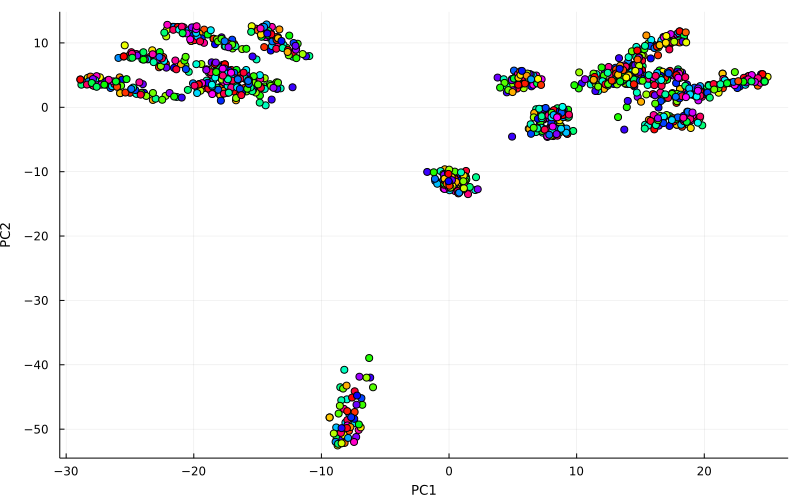

In [38]:
len_signatures = length(signatures_pos)+length(signatures_neg)
signatures_flipped = zeros(Int64, 10000, len_signatures)
labels = vcat([serotypes[key[1]] for (key, value) in signatures_pos], 
    [serotypes[key[1]] for (key, value) in signatures_neg])
colorscale = range(HSV(0,1,1), stop=HSV(-360,1,1), length=length(serotypes))

i = 1
for (key, value) in signatures_pos
    signatures_flipped[:,i] = value
    i = i+1
end
for (key, value) in signatures_neg
    signatures_flipped[:,i] = value
    i = i+1
end

pca = fit(MultivariateStats.PCA, signatures_flipped, pratio=1, maxoutdim=4);
signatures_transformed = MultivariateStats.transform(pca, signatures_flipped)

h = plot(seriestype=:scatter)
for i in 1:length(labels)
    loci_index = findall(x->x==labels[i], serotypes)[1]
    plot!([signatures_transformed[1, i]], [signatures_transformed[2, i]], seriestype=:scatter, 
        color=colorscale[loci_index], legend=false)
end
plot!(xlabel="PC1", xguidefontsize=9, ylabel="PC2", yguidefontsize=9, size=(800, 500), dpi=400)
display(h)

Here, we see the lower dimensional projection of the RBP-loci signatures, colored by unique RBP in the dataset (there are 19 unique RBPs that are validated by structure and pass the mono filter, leading to 29 positive interactions; 28/05/22). Interestingly, we see that the unique RBP-loci interactions cluster by RBP, not by pos/neg interactions nor by serotype. The differences between RBPs (who each target different serotypes) are more outspoken then the differences between pos/neg (even within one RBP cluster) or the differences between serotypes. Ideally, we would want to see a clustering as a result of both dimensions (the RBPs and the loci): so you would get individual clusters per unique combo of a RBP+locus.

BUT it's not because we don't see this in 2D, that we will not see this in higher dimensions. The only thing we can conclude here is that the weight of the information is at the RBP level.

#### PCA of the signatures colored by serotype AND pos+ only

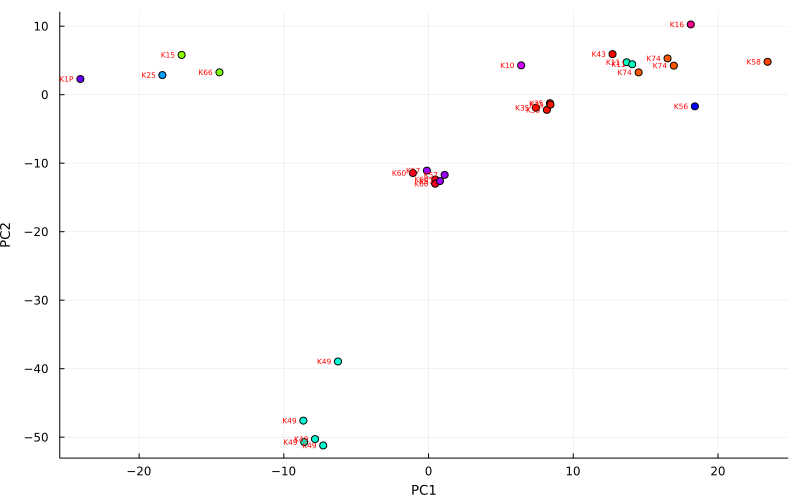

In [33]:
len_signatures = length(signatures_pos)+length(signatures_neg)
signatures_flipped = zeros(Int64, 10000, len_signatures)
labels = vcat([1 for x in signatures_pos], [0 for x in signatures_neg])
rbp_labels = vcat([rbp_names[key[2]] for (key, value) in signatures_pos], 
    [rbp_names[key[2]] for (key, value) in signatures_neg])
colorscale = range(HSV(0,1,1), stop=HSV(-360,1,1), length=length(rbp_names))

i = 1
for (key, value) in signatures_pos
    signatures_flipped[:,i] = value
    i = i+1
end
for (key, value) in signatures_neg
    signatures_flipped[:,i] = value
    i = i+1
end

pca = fit(MultivariateStats.PCA, signatures_flipped, pratio=1, maxoutdim=4);
signatures_transformed = MultivariateStats.transform(pca, signatures_flipped)

h = plot(seriestype=:scatter)
for i in 1:length(labels)
    if labels[i] == 1
        rbp_index = findall(x->x==rbp_labels[i], rbp_names)
        plot!([signatures_transformed[1, i]], [signatures_transformed[2, i]], seriestype=:scatter, 
            color=colorscale[rbp_index], legend=false)
        annotate!(signatures_transformed[1, i]-0.5, signatures_transformed[2, i], text(rbp_labels[i][1:3], :red, :right, 5))
    end
end
plot!(xlabel="PC1", xguidefontsize=9, ylabel="PC2", yguidefontsize=9, size=(800, 500), dpi=400)
display(h)

On this 4th figure with pos+ only, we for example see that RBPs targeting K57 and K60 appear to be quite similar, although the experimental data does not indicate cross-infectivity. So here, we see that similar RBPs can infect (perhaps also similar) serotypes without cross-infectivity.

#### PCA of the signatures within K49 and colored by pos/neg

We want to investigate if within one serotype, the separation between pos+ and neg- is clear or not. If so, then this indicates that we could learn to separate positives from negatives ones, at least within a serotype. If not, then this indicates that even within a serotype, the RBPs that target that serotype are not per se similar (can have evolved independently). But for our predictive framework, this should not be a problem because all we want is the model to rank these high -> It's OK is the pos+ ones are different from one another, as long as they are also different from neg- ones. Because then a new RBP can still be predicted as pos (it will be more similar in pattern to one or few of the pos+ ones, and dissimilar to the negative ones).

In [ ]:
len_signatures = length(signatures_pos)+length(signatures_neg)
signatures_flipped = zeros(Int64, 10000, len_signatures)
labels = vcat([serotypes[key[1]] for (key, value) in signatures_pos], 
    [serotypes[key[1]] for (key, value) in signatures_neg])

i = 1
for (key, value) in signatures_pos
    signatures_flipped[:,i] = value
    i = i+1
end
for (key, value) in signatures_neg
    signatures_flipped[:,i] = value
    i = i+1
end

pca = fit(MultivariateStats.PCA, signatures_flipped, pratio=1, maxoutdim=4);
signatures_transformed = MultivariateStats.transform(pca, signatures_flipped)

h = plot(seriestype=:scatter)
for i in 1:length(labels)
    loci_index = findall(x->x==labels[i], serotypes)[1]
    plot!([signatures_transformed[1, i]], [signatures_transformed[2, i]], seriestype=:scatter, 
        color=colorscale[loci_index], legend=false)
end
plot!(xlabel="PC1", xguidefontsize=9, ylabel="PC2", yguidefontsize=9, size=(800, 500), dpi=400)
display(h)

#### Exploring similarities between the embeddings

Idea: compute the cosine similarities between all HDC embeddings and compare that with alignment similarity scores.

##### a) RBP similarities

In [24]:
# do pairwise alignments (local or global)
score_matrix = zeros(length(RBPbase.ProteinSeq), length(RBPbase.ProteinSeq))
score_model = AffineGapScoreModel(BLOSUM62, gap_open=-5, gap_extend=-1)
p = Progress(Int64(round((length(RBPbase.ProteinSeq)^2/2), digits=0)))
for i in 1:length(RBPbase.ProteinSeq)
    for j in i:length(RBPbase.ProteinSeq)
        res = pairalign(GlobalAlignment(), RBPbase.ProteinSeq[i], RBPbase.ProteinSeq[j], score_model);
        aln = alignment(res)
        score_matrix[i,j] = count_matches(aln) / count_aligned(aln)
        next!(p)
    end
end

# complete the matrix and adjust the diagonal for double score
score_matrix = (score_matrix + score_matrix')
score_matrix = score_matrix - Diagonal(score_matrix)/2;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:25


88×88 Matrix{Float64}:
 1.0       0.224605  0.219608  0.237288  …  0.231237  0.231943  0.246502
 0.224605  1.0       0.218462  0.225237     0.25693   0.222462  0.208972
 0.219608  0.218462  1.0       0.221639     0.221289  0.23055   0.223394
 0.237288  0.225237  0.221639  1.0          0.21692   0.230599  0.230233
 0.185554  0.184366  0.164641  0.20598      0.176536  0.176334  0.180049
 0.214992  0.201835  0.218501  0.206061  …  0.22377   0.225225  0.221846
 0.209449  0.195876  0.219714  0.180016     0.212167  0.21189   0.222393
 0.233971  0.2237    0.21336   0.229114     0.325314  0.229145  0.224289
 0.262668  0.216805  0.234856  0.236324     0.226744  0.284577  0.379237
 0.224138  0.227848  0.197243  0.230245     0.226013  0.25162   0.26082
 0.335991  0.221704  0.224327  0.250323  …  0.207113  0.239496  0.250273
 0.241111  0.227001  0.218496  0.230179     0.322141  0.227418  0.230355
 0.209614  0.191693  0.22049   0.18124      0.206505  0.20505   0.224632
 ⋮                           

In [26]:
# compute cosine similarities for RBP embeddings
rbp_embeddings_sim = zeros(Float64, length(rbp_embeddings), length(rbp_embeddings))
for i in range(1, length=length(rbp_embeddings))
    for j in range(1, length=length(rbp_embeddings))
        rbp_embeddings_sim[i,j] = cos_sim(rbp_embeddings[i], rbp_embeddings[j])
    end
end

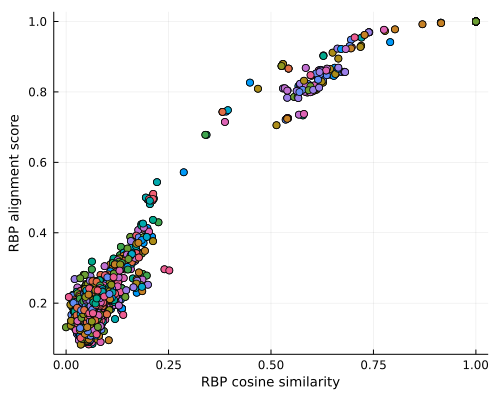

In [27]:
# Make RBP scatter plot
h = plot(seriestype=:scatter)
for i in range(1, length=length(rbp_embeddings))
    for j in range(1, length=length(rbp_embeddings))
        plot!([rbp_embeddings_sim[i, j]], [score_matrix[i, j]], seriestype=:scatter, label="")
    end
end
plot!(xlabel="RBP cosine similarity", xguidefontsize=9, ylabel="RBP alignment score", yguidefontsize=9, size=(500, 400), dpi=300)
display(h)

In [17]:
savefig(h, results_dir*"/HDC_scatter_RBPs_cosine_alignment.png")

In [28]:
# compute RBP correlation
flat_rbp_sim = vcat(rbp_sim...)
flat_rbp_embeddings_sim = vcat(rbp_embeddings_sim...)
cor(flat_rbp_sim, flat_rbp_embeddings_sim)

0.9587873654645828

##### b) Loci similarities

In [55]:
# compute loci embeddings w/ proteins (multi-instance)
basis = Dict(c=>BipolarHDV() for c in alphabet);
loci_embeddings = Array{BipolarHDV}(undef, length(LociBase))
for (i, (name, proteins)) in enumerate(LociBase)
    # bind within one sequence, then aggregate the different sequences
    protein_hdvs = [sequence_embedding(string(sequence), basis, 1) for sequence in proteins]
    loci_hdv = HyperdimensionalComputing.aggregate(protein_hdvs)
    loci_embeddings[i] = loci_hdv
end

In [56]:
# read loci alignment matrix
loci_sim = readdlm(general_dir*"/kaptive_results_all_loci.fasta_score_matrix.txt", '\t');

# compute cosine similarities for loci embeddings
loci_embeddings_sim = zeros(Float64, length(loci_embeddings), length(loci_embeddings))
for i in range(1, length=length(loci_embeddings))
    for j in range(1, length=length(loci_embeddings))
        loci_embeddings_sim[i,j] = cos_sim(loci_embeddings[i], loci_embeddings[j])
    end
end

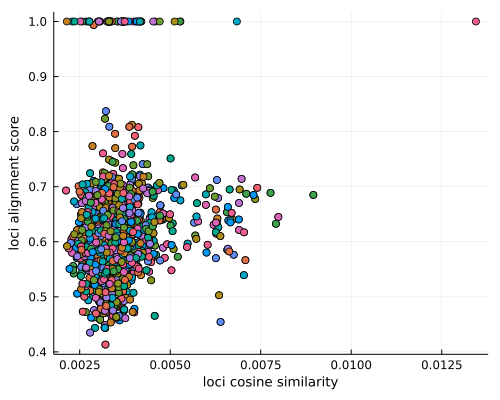

In [57]:
# Make loci scatter plot
h = plot(seriestype=:scatter)
for i in range(1, length=length(loci_embeddings))
    for j in range(1, length=length(loci_embeddings))
        plot!([loci_embeddings_sim[i, j]], [loci_sim[i, j]], seriestype=:scatter, label="")
    end
end
plot!(xlabel="loci cosine similarity", xguidefontsize=9, ylabel="loci alignment score", yguidefontsize=9, size=(500, 400), dpi=300)
display(h)

In [21]:
savefig(h, results_dir*"/HDC_scatter_locibind_cosine_alignment.png")

In [58]:
# compute loci correlation
flat_loci_sim = vcat(loci_sim...)
flat_loci_embeddings_sim = vcat(loci_embeddings_sim...)
cor(flat_loci_sim, flat_loci_embeddings_sim)

0.16215190522417983

We see that the correlation between the RBP embeddings scores and alignment scores is very good, which indicates that the (evolutionary) information of the RBPs is well captured in the embeddings (for as far as we can see alignment as a proxy for this information). However, for the loci embeddings, we don't see quite a high correlation between the alignment scores and embedding similarities. This could be due to several reasons:

- there is a disconnection between the similarity score of alignments at the DNA level and the embeddings in a multi-instance setting at the protein level.
- alignment itself is a bad measure for similarity for these long stretches of DNA (or the particular type of alignment).
- the computed embeddings don't contain the information we want and/or multi-instance setting is not well defined/computed.

Sometimes we get a slightly better result, a correlation of around 57% with a BipolarHDV. Depends on the random nature of the vectors too I suppose. But still not amazingly good.

##### c) Further analysis of loci similarities

We will try a second approach: compute the similarities between all loci proteins separately, both with alignment and embeddings, and then compare both. If they turn out appropriately, then the problem is either the loci alignment itself or the multi-instance combo.

In [24]:
# get all proteins in a list
all_loci_proteins = []
for (key, value) in LociBase
    for protein in value
        push!(all_loci_proteins, protein)
    end
end

In [29]:
# do pairwise alignments
score_matrix = zeros(length(all_loci_proteins), length(all_loci_proteins))
score_model = AffineGapScoreModel(BLOSUM62, gap_open=-5, gap_extend=-1)
p = Progress(Int64(round((length(all_loci_proteins)^2/2), digits=0)))
for i in 1:length(all_loci_proteins)
    for j in i:length(all_loci_proteins)
        res = pairalign(LocalAlignment(), all_loci_proteins[i], all_loci_proteins[j], score_model);
        aln = alignment(res)
        score_matrix[i,j] = count_matches(aln) / count_aligned(aln)
        next!(p)
    end
end

# complete the matrix and adjust the diagonal for double score
score_matrix = (score_matrix + score_matrix')
score_matrix = score_matrix - Diagonal(score_matrix)/2

Progress: 100%|█████████████████████████████████████████| Time: 0:20:31


1204×1204 Matrix{Float64}:
 1.0       0.211538  0.252475  0.245353  …  0.258786  0.244373  0.232
 0.211538  1.0       0.246809  0.226415     0.266949  0.237569  0.273973
 0.252475  0.246809  1.0       0.211401     0.229755  0.236538  0.254737
 0.245353  0.226415  0.211401  1.0          0.2277    0.262582  0.221461
 0.25      0.25974   0.309859  0.253623     0.294118  0.236364  0.22561
 0.247748  0.261468  0.208     0.236786  …  0.245487  0.208729  0.238197
 0.237342  0.208661  0.188406  0.231343     0.211679  0.204461  0.242105
 0.211429  0.232704  0.237192  0.216518     0.238956  0.228797  0.215054
 0.241497  0.243902  0.231061  0.223844     0.22069   0.217054  0.220657
 0.225225  0.27193   0.223565  0.237143     0.225118  0.197143  0.232416
 0.228758  0.237288  0.207877  0.232687  …  0.242925  0.21663   0.223476
 0.219828  0.205224  0.213235  0.2457       0.233151  0.188596  0.255319
 0.237143  0.238095  0.262443  0.221014     0.215054  0.233766  0.231608
 ⋮                          

In [40]:
# compute loci embeddings for all proteins 
basis = Dict(c=>BipolarHDV() for c in alphabet);
loci_embeddings = Array{BipolarHDV}(undef, length(all_loci_proteins))
for (i, protein) in enumerate(all_loci_proteins)
    protein_hdv = sequence_embedding(string(protein), basis, 3)
    loci_embeddings[i] = protein_hdv
end

In [41]:
# compute cosine similarities for all loci proteins
loci_embeddings_sim = zeros(Float64, length(loci_embeddings), length(loci_embeddings))
for i in 1:length(loci_embeddings)
    for j in 1:length(loci_embeddings)
        loci_embeddings_sim[i,j] = cos_sim(loci_embeddings[i], loci_embeddings[j])
    end
end

In [43]:
# Make loci scatter plot
flat_loci_sim = vcat(score_matrix...)
flat_loci_embeddings_sim = vcat(loci_embeddings_sim...)
h = plot(seriestype=:scatter)
for i in range(1, length=20000)
    plot!([flat_loci_embeddings_sim[i]], [flat_loci_sim[i]], seriestype=:scatter, label="")
end
plot!(xlabel="loci proteins cosine similarity", xguidefontsize=9, ylabel="loci alignment score", yguidefontsize=9, size=(500, 400), dpi=300)
display(h)

In [45]:
savefig(h, results_dir*"/HDC_scatter_individuallociproteins_cosine_alignment.png")

In [44]:
cor(flat_loci_sim, flat_loci_embeddings_sim)

0.9401870360921616

## 4 - Simple evaluation

In [13]:
# covert dictionaries to arrays for training
sign_pos_list = [value for (key, value) in signatures_pos]
sign_neg_list = [value for (key, value) in signatures_neg]
signatures_pos_array = convert(Array{BipolarHDV}, sign_pos_list)
signatures_neg_array = convert(Array{BipolarHDV}, sign_neg_list);

In [14]:
# shuffle and split in train-test
sign_pos = shuffle(signatures_pos_array)
sign_neg = shuffle(signatures_neg_array)
cutoff_pos = Int(round(length(signatures_pos_array)*0.75))
cutoff_neg = Int(round(length(signatures_neg_array)*0.75))
training_pos = sign_pos[1:cutoff_pos]
training_neg = sign_neg[1:cutoff_neg]
testing_pos = sign_pos[cutoff_pos+1:end]
testing_neg = sign_neg[cutoff_neg+1:end]

# train classes (aggregate)
training_pos_agg = HyperdimensionalComputing.aggregate(training_pos)
training_neg_agg = HyperdimensionalComputing.aggregate(training_neg);

In [15]:
# compute distances (Cosine sim for RealHDVs)
preds_pos = [cos_sim(training_pos_agg, x) > cos_sim(training_neg_agg, x) ? 1 : 0 for x in testing_pos]
preds_neg = [cos_sim(training_pos_agg, x) > cos_sim(training_neg_agg, x) ? 1 : 0 for x in testing_neg];

In [16]:
accuracy = (sum(preds_pos .== 1) + sum(preds_neg .== 0)) / (length(testing_pos)+length(testing_neg))

0.02258064516129032

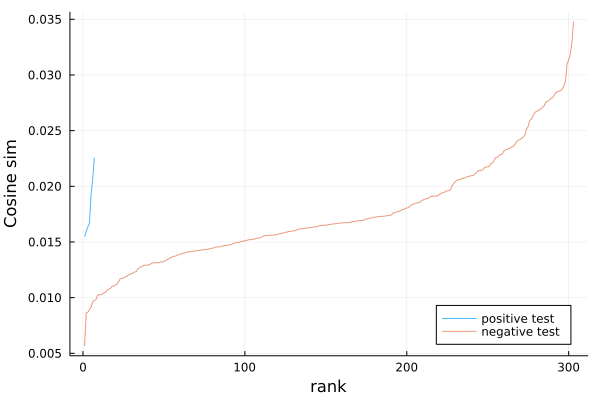

In [197]:
dist_pos_test = [cos_sim(training_pos_agg, x) for x in testing_pos]
dist_neg_test = [cos_sim(training_pos_agg, x) for x in testing_neg]

# make plots
hist = histogram(dist_pos_test, label="positive test", alpha=0.7, legend=:topleft, nbins=40)
histogram!(dist_neg_test, label="negative test", alpha=0.7, nbins=30)
#savefig(hist, results_dir*"/HDC_histogram.png")

rank_plot = plot(sort!(dist_pos_test), label="positive test", alpha=0.7, legend=:bottomright, xlabel="rank", ylabel="Cosine sim")
plot!(sort!(dist_neg_test), label="negative test", alpha=0.7)
#savefig(rank_plot, results_dir*"/HDC_rank_plot.png")

If we compute the accuracy very naively, we get a very bad result. In essence, the similarity to the positive aggregated vector will always be greater than the similarity to the negative aggregate, and thus all predictions are positive...

We also see this difficulty on a histogram, the positive scores overlap completely with the negative scores. However, a rank plot does seem to indicate that overall, separation between pos+ and negatives can be possible. This is what we should check out: if we predict for all of the bacterial strains, how do these scores compare: do the positive interactions have greater scores than the negative interactions, given a particular bacterial strain?!

## 5 - Cross-validation

In this section, we will try to answer the question above by implementing a Stratified KFold approach that loops over all of the data points and makes predictions. These predictions are then collected in a matrix with the same shape as our interaction matrix. 

This prediction matrix is then ranked using the scores to get a sense of where the positive interactions occur for each bacterial strain. These ranks are then used to compute the mean reciprocal rank over the rows (thus over the bacterial strains, just as we would use the framework in practice).

The tricky part is that we have VERY few positive examples, and one of our ideas is to only compute similarities to the positively aggregated class. Therefore, an important assumption we make is that the positive aggregate in each iteration of the cross validation is equally representative of the entire positive aggregate (as a whole, in general). To have this assumption hold, we will use a 10-fold cross-validation, which means that 90% of the data is used for training in each iteration. Our assumption therefore is that 90% of the positive data is a good representation of the entire positive training data.

Update 1/07/22: let's try an even more extreme case: LOOCV! If this improves, then the problem resides at the level of the number of datapoints the model can learn from (90% in K-fold training but Klebsiella phages infect around 2% of their hosts...). If this doesn't improve, then the problem is more fundamental (even more data needed, feature engineering not on point, ...).

In [15]:
# covert dictionaries to arrays for training
sign_pos_list = [value for (key, value) in signatures_pos]
sign_neg_list = [value for (key, value) in signatures_neg]
signatures_pos_array = convert(Array{BipolarHDV}, sign_pos_list)
signatures_neg_array = convert(Array{BipolarHDV}, sign_neg_list);

In [16]:
# aggregate the signatures, labels and positions for cross-validation
signatures = vcat(signatures_pos_array, signatures_neg_array)
labels = vcat([1 for x in signatures_pos], [0 for x in signatures_neg])
positions = vcat([key for (key, value) in signatures_pos], [key for (key, value) in signatures_neg]);

#### a) HDC model that only considers the positive aggregate

In [41]:
# perform the cross-validation and keep the scores
#similarities = Dict()
similarities = zeros(Float64, length(loci_embeddings), length(rbp_embeddings))
#for (train_indices, test_indices) in CrossValidation.StratifiedKFold(labels, n_folds=10, 
#        shuffle=true, random_state=42)
for (test, train_indices) in enumerate(LOOCV(length(signatures)))
    # define training and test data
    x_train = signatures[train_indices]
    y_train = labels[train_indices]
    x_test = signatures[test]
    y_test = labels[test]
    
    # train the positive aggregate
    pos_aggregate = HyperdimensionalComputing.aggregate(x_train[y_train .== 1])
    pos_i, pos_j = positions[test][1], positions[test][2]
    similarities[pos_i, pos_j] = cos_sim(pos_aggregate, x_test)
    
    # compute similarities to the pos aggregate and keep the index
    #similarities_k = [cos_sim(pos_aggregate, x) for x in x_test]
    #for (i, test_i) in enumerate(test_indices)
    #    pos_i, pos_j = positions[test_i][1], positions[test_i][2]
    #    similarities[pos_i, pos_j] = similarities_k[i]
    #end
end

In [207]:
missing_cols = [col for col in 1:size(interaction_matrix)[2] if sum(ismissing.(interaction_matrix[:, col])) > 0]
missing_sims = [col for col in 1:size(similarities)[2] if sum(similarities[:, col]) == 0]
@test missing_cols == missing_sims

Test Passed

In [42]:
mrr_from_scores(similarities, interaction_matrix)

0.09480120897777944

#### b) HDC model that considers both positive and negative aggregates

In [209]:
# perform the cross-validation and keep the scores
#similarities = Dict()
similarities = zeros(Float64, length(loci_embeddings), length(rbp_embeddings))
for (train_indices, test_indices) in CrossValidation.StratifiedKFold(labels, n_folds=10, 
        shuffle=true, random_state=42)
    # define training and test data
    x_train = signatures[train_indices]
    y_train = labels[train_indices]
    x_test = signatures[test_indices]
    y_test = labels[test_indices]
    
    # train the aggregates
    centers = train(y_train, x_train)
    
    # compute ratio of similarities to aggregates (centers[0] -> neg-, centers[1] -> pos+) and keep the index
    similarities_k = [cos_sim(centers[1], x)/cos_sim(centers[0], x) for x in x_test]
    for (i, test_i) in enumerate(test_indices)
        pos_i, pos_j = positions[test_i][1], positions[test_i][2]
        similarities[pos_i, pos_j] = similarities_k[i]
    end
end

But this isn't really satisfactory because if the sim scores to pos aggregate are negative, things shift from interpretation (the higher the ratio the closer to pos+ aggregate will not hold anymore... check notes)

In [210]:
mrr_from_scores(similarities, interaction_matrix)

0.1394852301398791

#### c) SKLEARN PCA + RF model

https://github.com/cstjean/ScikitLearn.jl/blob/master/examples/Pipeline_PCA_Logistic.ipynb

In [15]:
# put the signatures in a matrix for sklearn
signatures_matrix = zeros(Int64, length(signatures), 10000)
for i in range(1, length=length(signatures))
    signatures_matrix[i,:] = signatures[i]
end

In [16]:
rf = RandomForestClassifier(n_estimators=500, class_weight="balanced")
pca = PCA(n_components=300)
pipe = Pipeline([("pca", pca), ("rf", rf)])

# perform the cross-validation and keep the scores
similarities = zeros(Float64, length(loci_embeddings), length(rbp_embeddings))
scores_flat = zeros(Float64, length(signatures))

similarities = zeros(Float64, length(loci_embeddings), length(rbp_embeddings))
for (train_indices, test_indices) in CrossValidation.StratifiedKFold(labels, n_folds=10, 
        shuffle=true, random_state=42)
    # define training and test data
    x_train = signatures_matrix[train_indices, :]
    y_train = labels[train_indices]
    x_test = signatures_matrix[test_indices, :]
    y_test = labels[test_indices]
    
    # train the model
    model = ScikitLearn.fit!(pipe, x_train, y_train)
    
    # make predictions and keep the scores
    scores_pos = ScikitLearn.predict_proba(model, x_test)[:,2]
    
    for (i, test_i) in enumerate(test_indices)
        pos_i, pos_j = positions[test_i][1], positions[test_i][2]
        similarities[pos_i, pos_j] = scores_pos[i]
        scores_flat[test_i] = scores_pos[i]
    end
end

In [21]:
auc_from_scores(scores_flat, labels)

0.6094137076796037

In [22]:
mrr_from_scores(similarities, interaction_matrix)

0.10615852620309325

#### d) XGBoost classifier

In [37]:
imbalance = length(signatures_pos)/length(signatures_neg);

In [41]:
# perform the cross-validation and keep the scores
similarities = zeros(Float64, length(loci_embeddings), length(rbp_embeddings))
scores_flat = zeros(Float64, length(signatures))

for (train_indices, test_indices) in CrossValidation.StratifiedKFold(labels, n_folds=10, 
        shuffle=true, random_state=42)
    # define training and test data
    x_train = signatures_matrix[train_indices, :]
    y_train = labels[train_indices]
    x_test = signatures_matrix[test_indices, :]
    y_test = labels[test_indices]
    
    # train the model
    pca = PCA(n_components=300)
    x_train_r = pca.fit_transform(x_train)
    model = xgboost(x_train_r, 500, label=y_train, scale_pos_weight=1/imbalance)
    
    # make predictions and keep the scores
    x_test_r = pca.transform(x_test)
    scores_pos = XGBoost.predict(model, x_test_r)
    
    for (i, test_i) in enumerate(test_indices)
        pos_i, pos_j = positions[test_i][1], positions[test_i][2]
        similarities[pos_i, pos_j] = scores_pos[i]
        scores_flat[test_i] = scores_pos[i]
    end
end

[1]	train-rmse:0.37204574132608642
[2]	train-rmse:0.29315316119212975
[3]	train-rmse:0.22633603844565900
[4]	train-rmse:0.17003835800434819
[5]	train-rmse:0.13606770786141886
[6]	train-rmse:0.10714191301571338
[7]	train-rmse:0.08681837329970161
[8]	train-rmse:0.07200226509886259
[9]	train-rmse:0.06209514668713721
[10]	train-rmse:0.05464283424873471
[11]	train-rmse:0.04927780073682679
[12]	train-rmse:0.04457682264247204
[13]	train-rmse:0.04031628601234689
[14]	train-rmse:0.03530517616085280
[15]	train-rmse:0.03213423611507901
[16]	train-rmse:0.02910288532863854
[17]	train-rmse:0.02645902691838704
[18]	train-rmse:0.02520355097263080
[19]	train-rmse:0.02386729612136029
[20]	train-rmse:0.02330706937997119
[21]	train-rmse:0.02210069052403320
[22]	train-rmse:0.02118386880400707
[23]	train-rmse:0.01970512459148280
[24]	train-rmse:0.01935409606254427
[25]	train-rmse:0.01871870918076230
[26]	train-rmse:0.01757656134547991
[27]	train-rmse:0.01730194212131667
[28]	train-rmse:0.01674255998750504
[

[281]	train-rmse:0.00047228542325970
[282]	train-rmse:0.00047228542326014
[283]	train-rmse:0.00047228542326034
[284]	train-rmse:0.00047228542326042
[285]	train-rmse:0.00047228542326078
[286]	train-rmse:0.00047228542326112
[287]	train-rmse:0.00047228542326138
[288]	train-rmse:0.00047228542326176
[289]	train-rmse:0.00047228542326203
[290]	train-rmse:0.00047228542326216
[291]	train-rmse:0.00047228542326261
[292]	train-rmse:0.00047228542326274
[293]	train-rmse:0.00047228542326302
[294]	train-rmse:0.00047228542326345
[295]	train-rmse:0.00047228542326382
[296]	train-rmse:0.00047228542326408
[297]	train-rmse:0.00047228542326432
[298]	train-rmse:0.00047228542326459
[299]	train-rmse:0.00047228542326484
[300]	train-rmse:0.00047228542326528
[301]	train-rmse:0.00047228542326548
[302]	train-rmse:0.00047228542326549
[303]	train-rmse:0.00047228542326550
[304]	train-rmse:0.00047228542326549
[305]	train-rmse:0.00047228542326552
[306]	train-rmse:0.00047228542326551
[307]	train-rmse:0.00047228542326551
[

[61]	train-rmse:0.00628666461522972
[62]	train-rmse:0.00618353877088247
[63]	train-rmse:0.00592797422654996
[64]	train-rmse:0.00579359109122586
[65]	train-rmse:0.00573077312995959
[66]	train-rmse:0.00547661489870749
[67]	train-rmse:0.00525032427932035
[68]	train-rmse:0.00512151687133623
[69]	train-rmse:0.00502068207100450
[70]	train-rmse:0.00495894751080076
[71]	train-rmse:0.00462432819466373
[72]	train-rmse:0.00452297581439406
[73]	train-rmse:0.00435246441703399
[74]	train-rmse:0.00430270498576027
[75]	train-rmse:0.00419476741800215
[76]	train-rmse:0.00413161197703759
[77]	train-rmse:0.00404386950381665
[78]	train-rmse:0.00392678593536473
[79]	train-rmse:0.00376752886526988
[80]	train-rmse:0.00356275074505500
[81]	train-rmse:0.00341965998837328
[82]	train-rmse:0.00331076337358637
[83]	train-rmse:0.00315806082034332
[84]	train-rmse:0.00307876738244031
[85]	train-rmse:0.00301398582399979
[86]	train-rmse:0.00295455980977993
[87]	train-rmse:0.00283004394381470
[88]	train-rmse:0.0026511393

[339]	train-rmse:0.00045906981108883
[340]	train-rmse:0.00045906981108875
[341]	train-rmse:0.00045906981108868
[342]	train-rmse:0.00045906981108865
[343]	train-rmse:0.00045906981108859
[344]	train-rmse:0.00045906981108851
[345]	train-rmse:0.00045906981108844
[346]	train-rmse:0.00045906981108838
[347]	train-rmse:0.00045906981108832
[348]	train-rmse:0.00045906981108829
[349]	train-rmse:0.00045906981108822
[350]	train-rmse:0.00045906981108814
[351]	train-rmse:0.00045906981108809
[352]	train-rmse:0.00045906981108801
[353]	train-rmse:0.00045906981108799
[354]	train-rmse:0.00045906981108792
[355]	train-rmse:0.00045906981108786
[356]	train-rmse:0.00045906981108778
[357]	train-rmse:0.00045906981108774
[358]	train-rmse:0.00045906981108765
[359]	train-rmse:0.00045906981108762
[360]	train-rmse:0.00045906981108755
[361]	train-rmse:0.00045906981108749
[362]	train-rmse:0.00045906981108742
[363]	train-rmse:0.00045906981108734
[364]	train-rmse:0.00045906981108732
[365]	train-rmse:0.00045906981108725
[

[119]	train-rmse:0.00068728544682256
[120]	train-rmse:0.00066287623689541
[121]	train-rmse:0.00063872531474905
[122]	train-rmse:0.00062157216007887
[123]	train-rmse:0.00061453446925366
[124]	train-rmse:0.00059767131594257
[125]	train-rmse:0.00059314862436369
[126]	train-rmse:0.00055726355497334
[127]	train-rmse:0.00051714758469908
[128]	train-rmse:0.00050032267422059
[129]	train-rmse:0.00047090959182024
[130]	train-rmse:0.00047090680102185
[131]	train-rmse:0.00047090483414299
[132]	train-rmse:0.00047090348510993
[133]	train-rmse:0.00047090249800752
[134]	train-rmse:0.00047090181588363
[135]	train-rmse:0.00047090134011775
[136]	train-rmse:0.00047090093615810
[137]	train-rmse:0.00047090059188244
[138]	train-rmse:0.00047090029931063
[139]	train-rmse:0.00047090005136947
[140]	train-rmse:0.00047089984207276
[141]	train-rmse:0.00047089966663643
[142]	train-rmse:0.00047089951333074
[143]	train-rmse:0.00047089938664532
[144]	train-rmse:0.00047089927863559
[145]	train-rmse:0.00047089918615339
[

[397]	train-rmse:0.00047089866746923
[398]	train-rmse:0.00047089866746924
[399]	train-rmse:0.00047089866746926
[400]	train-rmse:0.00047089866746928
[401]	train-rmse:0.00047089866746930
[402]	train-rmse:0.00047089866746931
[403]	train-rmse:0.00047089866746933
[404]	train-rmse:0.00047089866746934
[405]	train-rmse:0.00047089866746936
[406]	train-rmse:0.00047089866746937
[407]	train-rmse:0.00047089866746939
[408]	train-rmse:0.00047089866746940
[409]	train-rmse:0.00047089866746942
[410]	train-rmse:0.00047089866746942
[411]	train-rmse:0.00047089866746945
[412]	train-rmse:0.00047089866746946
[413]	train-rmse:0.00047089866746947
[414]	train-rmse:0.00047089866746949
[415]	train-rmse:0.00047089866746951
[416]	train-rmse:0.00047089866746952
[417]	train-rmse:0.00047089866746953
[418]	train-rmse:0.00047089866746955
[419]	train-rmse:0.00047089866746956
[420]	train-rmse:0.00047089866746959
[421]	train-rmse:0.00047089866746959
[422]	train-rmse:0.00047089866746961
[423]	train-rmse:0.00047089866746963
[

[177]	train-rmse:0.00047592903985130
[178]	train-rmse:0.00047592903983827
[179]	train-rmse:0.00047592903982191
[180]	train-rmse:0.00047592903983146
[181]	train-rmse:0.00047592903982148
[182]	train-rmse:0.00047592903980433
[183]	train-rmse:0.00047592903981550
[184]	train-rmse:0.00047592903983206
[185]	train-rmse:0.00047592903983869
[186]	train-rmse:0.00047592903985592
[187]	train-rmse:0.00047592903986909
[188]	train-rmse:0.00047592903987666
[189]	train-rmse:0.00047592903987834
[190]	train-rmse:0.00047592903989561
[191]	train-rmse:0.00047592903990302
[192]	train-rmse:0.00047592903990770
[193]	train-rmse:0.00047592903991898
[194]	train-rmse:0.00047592903992351
[195]	train-rmse:0.00047592903992702
[196]	train-rmse:0.00047592903993125
[197]	train-rmse:0.00047592903993569
[198]	train-rmse:0.00047592903994087
[199]	train-rmse:0.00047592903994340
[200]	train-rmse:0.00047592903994804
[201]	train-rmse:0.00047592903995165
[202]	train-rmse:0.00047592903995461
[203]	train-rmse:0.00047592903996003
[

[455]	train-rmse:0.00047592904004109
[456]	train-rmse:0.00047592904004110
[457]	train-rmse:0.00047592904004112
[458]	train-rmse:0.00047592904004113
[459]	train-rmse:0.00047592904004114
[460]	train-rmse:0.00047592904004115
[461]	train-rmse:0.00047592904004116
[462]	train-rmse:0.00047592904004117
[463]	train-rmse:0.00047592904004118
[464]	train-rmse:0.00047592904004119
[465]	train-rmse:0.00047592904004120
[466]	train-rmse:0.00047592904004122
[467]	train-rmse:0.00047592904004123
[468]	train-rmse:0.00047592904004124
[469]	train-rmse:0.00047592904004125
[470]	train-rmse:0.00047592904004126
[471]	train-rmse:0.00047592904004128
[472]	train-rmse:0.00047592904004129
[473]	train-rmse:0.00047592904004130
[474]	train-rmse:0.00047592904004132
[475]	train-rmse:0.00047592904004132
[476]	train-rmse:0.00047592904004134
[477]	train-rmse:0.00047592904004135
[478]	train-rmse:0.00047592904004136
[479]	train-rmse:0.00047592904004137
[480]	train-rmse:0.00047592904004138
[481]	train-rmse:0.00047592904004139
[

[235]	train-rmse:0.00049037683424926
[236]	train-rmse:0.00049037683425080
[237]	train-rmse:0.00049037683425265
[238]	train-rmse:0.00049037683425296
[239]	train-rmse:0.00049037683425437
[240]	train-rmse:0.00049037683425621
[241]	train-rmse:0.00049037683425816
[242]	train-rmse:0.00049037683425853
[243]	train-rmse:0.00049037683425912
[244]	train-rmse:0.00049037683425974
[245]	train-rmse:0.00049037683426037
[246]	train-rmse:0.00049037683426105
[247]	train-rmse:0.00049037683426156
[248]	train-rmse:0.00049037683426223
[249]	train-rmse:0.00049037683426286
[250]	train-rmse:0.00049037683426357
[251]	train-rmse:0.00049037683426409
[252]	train-rmse:0.00049037683426478
[253]	train-rmse:0.00049037683426540
[254]	train-rmse:0.00049037683426594
[255]	train-rmse:0.00049037683426657
[256]	train-rmse:0.00049037683426716
[257]	train-rmse:0.00049037683426783
[258]	train-rmse:0.00049037683426840
[259]	train-rmse:0.00049037683426916
[260]	train-rmse:0.00049037683426977
[261]	train-rmse:0.00049037683427032
[

[13]	train-rmse:0.04570486286923729
[14]	train-rmse:0.04325110132297371
[15]	train-rmse:0.03907750579727096
[16]	train-rmse:0.03725277427462523
[17]	train-rmse:0.03405833295928325
[18]	train-rmse:0.03220377081134318
[19]	train-rmse:0.02900962206131491
[20]	train-rmse:0.02726673289087134
[21]	train-rmse:0.02482348935352480
[22]	train-rmse:0.02375356501997231
[23]	train-rmse:0.02281555087353107
[24]	train-rmse:0.02186012327852748
[25]	train-rmse:0.02067926398673836
[26]	train-rmse:0.01977452694325737
[27]	train-rmse:0.01876761433549731
[28]	train-rmse:0.01814256253848061
[29]	train-rmse:0.01773642468573259
[30]	train-rmse:0.01725801857526637
[31]	train-rmse:0.01649560362781991
[32]	train-rmse:0.01608939555905856
[33]	train-rmse:0.01547421963794301
[34]	train-rmse:0.01485249939509474
[35]	train-rmse:0.01438408517062684
[36]	train-rmse:0.01411153887909751
[37]	train-rmse:0.01384079470930469
[38]	train-rmse:0.01328174242875525
[39]	train-rmse:0.01280088830021043
[40]	train-rmse:0.0120447800

[293]	train-rmse:0.00047871265100948
[294]	train-rmse:0.00047871265100964
[295]	train-rmse:0.00047871265100978
[296]	train-rmse:0.00047871265100994
[297]	train-rmse:0.00047871265101013
[298]	train-rmse:0.00047871265101024
[299]	train-rmse:0.00047871265101039
[300]	train-rmse:0.00047871265101053
[301]	train-rmse:0.00047871265101069
[302]	train-rmse:0.00047871265101083
[303]	train-rmse:0.00047871265101095
[304]	train-rmse:0.00047871265101113
[305]	train-rmse:0.00047871265101129
[306]	train-rmse:0.00047871265101142
[307]	train-rmse:0.00047871265101154
[308]	train-rmse:0.00047871265101171
[309]	train-rmse:0.00047871265101185
[310]	train-rmse:0.00047871265101200
[311]	train-rmse:0.00047871265101212
[312]	train-rmse:0.00047871265101230
[313]	train-rmse:0.00047871265101243
[314]	train-rmse:0.00047871265101259
[315]	train-rmse:0.00047871265101276
[316]	train-rmse:0.00047871265101287
[317]	train-rmse:0.00047871265101303
[318]	train-rmse:0.00047871265101319
[319]	train-rmse:0.00047871265101331
[

[73]	train-rmse:0.00379890081831246
[74]	train-rmse:0.00354466278437701
[75]	train-rmse:0.00345948913556298
[76]	train-rmse:0.00330542127664606
[77]	train-rmse:0.00308804870671937
[78]	train-rmse:0.00302588933002634
[79]	train-rmse:0.00298699750333529
[80]	train-rmse:0.00288643901489425
[81]	train-rmse:0.00282642747434369
[82]	train-rmse:0.00274779961049950
[83]	train-rmse:0.00263658199890923
[84]	train-rmse:0.00257558382279375
[85]	train-rmse:0.00245736992370059
[86]	train-rmse:0.00236191033459237
[87]	train-rmse:0.00229102690335025
[88]	train-rmse:0.00223680681539500
[89]	train-rmse:0.00211958174147894
[90]	train-rmse:0.00203115728689876
[91]	train-rmse:0.00192073342543996
[92]	train-rmse:0.00183583201508079
[93]	train-rmse:0.00174497357260980
[94]	train-rmse:0.00162422206362871
[95]	train-rmse:0.00159451816545545
[96]	train-rmse:0.00155700280234048
[97]	train-rmse:0.00149636989101239
[98]	train-rmse:0.00141424362011975
[99]	train-rmse:0.00139754197636268
[100]	train-rmse:0.001376132

[351]	train-rmse:0.00046441760161809
[352]	train-rmse:0.00046441760161793
[353]	train-rmse:0.00046441760161777
[354]	train-rmse:0.00046441760161758
[355]	train-rmse:0.00046441760161742
[356]	train-rmse:0.00046441760161724
[357]	train-rmse:0.00046441760161710
[358]	train-rmse:0.00046441760161691
[359]	train-rmse:0.00046441760161673
[360]	train-rmse:0.00046441760161662
[361]	train-rmse:0.00046441760161641
[362]	train-rmse:0.00046441760161626
[363]	train-rmse:0.00046441760161613
[364]	train-rmse:0.00046441760161595
[365]	train-rmse:0.00046441760161578
[366]	train-rmse:0.00046441760161558
[367]	train-rmse:0.00046441760161545
[368]	train-rmse:0.00046441760161526
[369]	train-rmse:0.00046441760161512
[370]	train-rmse:0.00046441760161498
[371]	train-rmse:0.00046441760161480
[372]	train-rmse:0.00046441760161466
[373]	train-rmse:0.00046441760161445
[374]	train-rmse:0.00046441760161433
[375]	train-rmse:0.00046441760161413
[376]	train-rmse:0.00046441760161398
[377]	train-rmse:0.00046441760161382
[

[131]	train-rmse:0.00049579513767494
[132]	train-rmse:0.00049579488857245
[133]	train-rmse:0.00049579467795418
[134]	train-rmse:0.00049579449804073
[135]	train-rmse:0.00049579434639115
[136]	train-rmse:0.00049579421782682
[137]	train-rmse:0.00049579410934124
[138]	train-rmse:0.00049579401423607
[139]	train-rmse:0.00049579393652717
[140]	train-rmse:0.00049579386948542
[141]	train-rmse:0.00049579381266543
[142]	train-rmse:0.00049579376459334
[143]	train-rmse:0.00049579372238516
[144]	train-rmse:0.00049579368617966
[145]	train-rmse:0.00049579365826926
[146]	train-rmse:0.00049579363174429
[147]	train-rmse:0.00049579361018216
[148]	train-rmse:0.00049579359254710
[149]	train-rmse:0.00049579357693370
[150]	train-rmse:0.00049579356337111
[151]	train-rmse:0.00049579355282127
[152]	train-rmse:0.00049579354402218
[153]	train-rmse:0.00049579353564444
[154]	train-rmse:0.00049579352856213
[155]	train-rmse:0.00049579352209606
[156]	train-rmse:0.00049579351807982
[157]	train-rmse:0.00049579351329365
[

[409]	train-rmse:0.00049579348988541
[410]	train-rmse:0.00049579348988542
[411]	train-rmse:0.00049579348988542
[412]	train-rmse:0.00049579348988543
[413]	train-rmse:0.00049579348988544
[414]	train-rmse:0.00049579348988545
[415]	train-rmse:0.00049579348988546
[416]	train-rmse:0.00049579348988546
[417]	train-rmse:0.00049579348988547
[418]	train-rmse:0.00049579348988548
[419]	train-rmse:0.00049579348988548
[420]	train-rmse:0.00049579348988549
[421]	train-rmse:0.00049579348988550
[422]	train-rmse:0.00049579348988551
[423]	train-rmse:0.00049579348988551
[424]	train-rmse:0.00049579348988553
[425]	train-rmse:0.00049579348988553
[426]	train-rmse:0.00049579348988554
[427]	train-rmse:0.00049579348988555
[428]	train-rmse:0.00049579348988556
[429]	train-rmse:0.00049579348988556
[430]	train-rmse:0.00049579348988557
[431]	train-rmse:0.00049579348988557
[432]	train-rmse:0.00049579348988558
[433]	train-rmse:0.00049579348988559
[434]	train-rmse:0.00049579348988560
[435]	train-rmse:0.00049579348988560
[

[189]	train-rmse:0.00051475068801096
[190]	train-rmse:0.00051475068804189
[191]	train-rmse:0.00051475068805485
[192]	train-rmse:0.00051475068806600
[193]	train-rmse:0.00051475068807747
[194]	train-rmse:0.00051475068808665
[195]	train-rmse:0.00051475068809525
[196]	train-rmse:0.00051475068810701
[197]	train-rmse:0.00051475068811993
[198]	train-rmse:0.00051475068812744
[199]	train-rmse:0.00051475068814431
[200]	train-rmse:0.00051475068815227
[201]	train-rmse:0.00051475068815933
[202]	train-rmse:0.00051475068816928
[203]	train-rmse:0.00051475068818561
[204]	train-rmse:0.00051475068819514
[205]	train-rmse:0.00051475068820037
[206]	train-rmse:0.00051475068820003
[207]	train-rmse:0.00051475068820065
[208]	train-rmse:0.00051475068819978
[209]	train-rmse:0.00051475068820117
[210]	train-rmse:0.00051475068820189
[211]	train-rmse:0.00051475068820134
[212]	train-rmse:0.00051475068820279
[213]	train-rmse:0.00051475068820141
[214]	train-rmse:0.00051475068820248
[215]	train-rmse:0.00051475068820209
[

[467]	train-rmse:0.00051475068820166
[468]	train-rmse:0.00051475068820167
[469]	train-rmse:0.00051475068820167
[470]	train-rmse:0.00051475068820167
[471]	train-rmse:0.00051475068820167
[472]	train-rmse:0.00051475068820167
[473]	train-rmse:0.00051475068820167
[474]	train-rmse:0.00051475068820168
[475]	train-rmse:0.00051475068820168
[476]	train-rmse:0.00051475068820168
[477]	train-rmse:0.00051475068820168
[478]	train-rmse:0.00051475068820168
[479]	train-rmse:0.00051475068820169
[480]	train-rmse:0.00051475068820169
[481]	train-rmse:0.00051475068820169
[482]	train-rmse:0.00051475068820169
[483]	train-rmse:0.00051475068820169
[484]	train-rmse:0.00051475068820169
[485]	train-rmse:0.00051475068820170
[486]	train-rmse:0.00051475068820169
[487]	train-rmse:0.00051475068820170
[488]	train-rmse:0.00051475068820170
[489]	train-rmse:0.00051475068820170
[490]	train-rmse:0.00051475068820169
[491]	train-rmse:0.00051475068820170
[492]	train-rmse:0.00051475068820170
[493]	train-rmse:0.00051475068820171
[

[247]	train-rmse:0.00048985142005155
[248]	train-rmse:0.00048985142005216
[249]	train-rmse:0.00048985142005234
[250]	train-rmse:0.00048985142005280
[251]	train-rmse:0.00048985142005315
[252]	train-rmse:0.00048985142005344
[253]	train-rmse:0.00048985142005400
[254]	train-rmse:0.00048985142005419
[255]	train-rmse:0.00048985142005461
[256]	train-rmse:0.00048985142005499
[257]	train-rmse:0.00048985142005534
[258]	train-rmse:0.00048985142005567
[259]	train-rmse:0.00048985142005607
[260]	train-rmse:0.00048985142005649
[261]	train-rmse:0.00048985142005673
[262]	train-rmse:0.00048985142005717
[263]	train-rmse:0.00048985142005745
[264]	train-rmse:0.00048985142005794
[265]	train-rmse:0.00048985142005816
[266]	train-rmse:0.00048985142005865
[267]	train-rmse:0.00048985142005914
[268]	train-rmse:0.00048985142005944
[269]	train-rmse:0.00048985142005987
[270]	train-rmse:0.00048985142006034
[271]	train-rmse:0.00048985142006074
[272]	train-rmse:0.00048985142006120
[273]	train-rmse:0.00048985142006147
[

In [42]:
auc_from_scores(scores_flat, labels)

0.5735072183148723

In [43]:
mrr_from_scores(similarities, interaction_matrix)

0.08894057253490865

In [62]:
preds

310-element Vector{Float32}:
 -0.0014957435
  0.19507653
 -0.0016629706
  0.039776094
 -0.0010916301
 -0.004571991
  0.061557107
  0.17757003
  0.035605583
  0.001012282
 -0.011097134
  0.0005071403
 -0.0013950758
  ⋮
  0.073597215
 -0.004382071
 -0.033529658
 -0.0033563417
  0.20226027
  0.25199577
 -0.062148716
 -0.003714077
 -0.041224383
  0.46225622
 -0.0064150603
 -0.0013784041

In [59]:
using ScikitLearn.CrossValidation: train_test_split
x_train, x_test, y_train, y_test = train_test_split(signatures_matrix, labels, test_size=0.25)
pca = PCA(n_components=200)
x_train_r = pca.fit_transform(x_train)
model = xgboost(x_train_r, 250, label=y_train, scale_pos_weight=1/imbalance)
x_test_r = pca.transform(x_test)
preds = XGBoost.predict(model, x_test_r)

[1]	train-rmse:0.35903177855215335
[2]	train-rmse:0.26628351760917168
[3]	train-rmse:0.19608054506519115
[4]	train-rmse:0.14648883005856830
[5]	train-rmse:0.11304971204476218
[6]	train-rmse:0.08734506232460189
[7]	train-rmse:0.06798905252988463
[8]	train-rmse:0.05338248462248800
[9]	train-rmse:0.04215892496048484
[10]	train-rmse:0.03498053803979221
[11]	train-rmse:0.03008852169041983
[12]	train-rmse:0.02542524088441879
[13]	train-rmse:0.02180012797246559
[14]	train-rmse:0.01897150344666777
[15]	train-rmse:0.01720256141996738
[16]	train-rmse:0.01511801396817781
[17]	train-rmse:0.01354522576484818
[18]	train-rmse:0.01161279534842396
[19]	train-rmse:0.01110972181555974
[20]	train-rmse:0.01026540508943834
[21]	train-rmse:0.00988706650028228
[22]	train-rmse:0.00920353006887373
[23]	train-rmse:0.00874650020098312
[24]	train-rmse:0.00852963363717754
[25]	train-rmse:0.00788402262406985
[26]	train-rmse:0.00733515828779457
[27]	train-rmse:0.00718350742238192
[28]	train-rmse:0.00698142633274376
[

310-element Vector{Float32}:
 -0.0014957435
  0.19507653
 -0.0016629706
  0.039776094
 -0.0010916301
 -0.004571991
  0.061557107
  0.17757003
  0.035605583
  0.001012282
 -0.011097134
  0.0005071403
 -0.0013950758
  ⋮
  0.073597215
 -0.004382071
 -0.033529658
 -0.0033563417
  0.20226027
  0.25199577
 -0.062148716
 -0.003714077
 -0.041224383
  0.46225622
 -0.0064150603
 -0.0013784041

In [60]:
sum(preds .> 0 .== y_test) / length(y_test)

0.5612903225806452

## X - Tests

In [69]:
@testset "tests for MRR" begin
    @test mean_reciprocal_rank([[0, 0, 0], [0, 1, 0], [1, 0, 0]]) == 0.5
    @test mean_reciprocal_rank([[1, 0, 0], [1, 1, 0], [1, 0, 0]]) == 1
    A = [0 0 0; 0 1 0; 1 0 0] # Matrix
    @test mean_reciprocal_rank(A) == 0.5
end;

Test Summary: | Pass  Total
tests for MRR |    3      3


In [51]:
@testset "tests for constructing relevant matrix" begin
    preds = [0 0 1; 1 1 0; 0 0 0]
    labels = [0 0 1; 1 1 0; 0 0 0]
    @test construct_relevant_matrix(preds, labels) == labels # all TPs
    preds = [0 0 0; 1 0 0; 0 0 0]
    labels = [0 0 1; 1 1 0; 0 0 0]
    @test construct_relevant_matrix(preds, labels) == [0 0 0; 1 0 0; 0 0 0] # missed TPs
    preds = [0 1 0; 1 1 0; 1 0 0]
    labels = [0 0 1; 1 1 0; 0 0 0]
    @test construct_relevant_matrix(preds, labels) == [0 0 0; 1 1 0; 0 0 0] # FPs
end;

Test Summary:                          | Pass  Total
tests for constructing relevant matrix |    3      3


In [122]:
@testset "tests for sorting label matrix" begin 
    rel = [0 0 1; 1 1 0; 0 0 0]
    scores = [0.5 0.3 1; 1 0.3 0.7; 0.2 0.3 0.3]
    @test sort_label_matrix(scores, rel) == [1 0 0; 1 0 1; 0 0 0]
    
    rel = [0 0 1; 1 1 0; 0 0 0]
    scores = [1 0.3 1; 1 0.3 0.7; 0.2 0.3 0.3] # equal score for 0 and 1
    @test sort_label_matrix(scores, rel) == [0 1 0; 1 0 1; 0 0 0] # equals will appear in ascending order
end;

Test Summary:                  | Pass  Total
tests for sorting label matrix |    2      2


In [124]:
@testset "tests pipeline" begin
    preds = [0 0 1; 0 1 0; 0 0 0]
    labels = [0 0 1; 1 1 0; 0 0 0]
    scores = [0 0.2 0.5; 0.3 0.2 0.1; 0.2 0.4 0.3]
    relm = construct_relevant_matrix(preds, labels)
    sortm = sort_label_matrix(scores, relm)
    @test construct_relevant_matrix(preds, labels) == [0 0 1; 0 1 0; 0 0 0]
    @test sort_relevant_matrix(relm, scores) == [1 0 0; 0 1 0; 0 0 0] 
    @test mean_reciprocal_rank(sortm) == 0.5
end;

Test Summary:  | Pass  Total
tests pipeline |    3      3


In [28]:
@testset "tests mrr from scores" begin
    labels = [0 0 1; 1 1 0; 0 0 0]
    scores = [0 0.2 0.5; 0.3 0.5 0.6; 0.2 0.4 0.3]
    @test mrr_from_scores(scores, labels, 0.4) == 0.5
end;

Test Summary:         | Pass  Total
tests mrr from scores |    1      1


## X - Legacy code